# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import  silhouette_score
from sklearn.cluster import KMeans
import src.SI as SI

In [49]:
def plot_clusters(data, labels, title, centers=None,
                  x_label="Dim 1", y_label="Dim 2", 
                  colors=('blue', 'orange', 'green', 'red'), alpha=0.7, 
                  center_color='black', center_marker='X', center_size=200):
    
    if centers is not None:
        n_clusters = centers.shape[0]
        x_coords, y_coords = centers[:, 0], centers[:, 1]

        idx_to_color = {}
        assigned_indices = set()
        used_colors = set()

        # 1. Assign furthest left
        left_idx = np.argmin(x_coords)
        if left_idx not in assigned_indices:
            idx_to_color[left_idx] = colors[0]
            assigned_indices.add(left_idx)
            used_colors.add(colors[0])

        # 2. Assign furthest right
        right_idx = np.argmax(x_coords)
        if right_idx not in assigned_indices:
            idx_to_color[right_idx] = colors[1]
            assigned_indices.add(right_idx)
            used_colors.add(colors[1])

        # 3. Assign furthest up
        up_idx = np.argmax(y_coords)
        if up_idx not in assigned_indices:
            idx_to_color[up_idx] = colors[2]
            assigned_indices.add(up_idx)
            used_colors.add(colors[2])

        # 4. Assign furthest down
        down_idx = np.argmin(y_coords)
        if down_idx not in assigned_indices:
            idx_to_color[down_idx] = colors[3]
            assigned_indices.add(down_idx)
            used_colors.add(colors[3])

        # 5. Assign remaining (inscribed) clusters with remaining colors
        available_colors = [c for c in colors if c not in used_colors]
        for idx in range(n_clusters):
            if idx not in assigned_indices:
                if available_colors:
                    idx_to_color[idx] = available_colors.pop(0)
                else:
                    idx_to_color[idx] = 'gray'  # fallback if not enough colors

        # Assign colors to points
        point_colors = [idx_to_color[label] for label in labels]
    else:
        # fallback if centers are not provided
        point_colors = labels

    plt.scatter(data[:, 0], data[:, 1], c=point_colors, alpha=alpha)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], 
                    c=center_color, 
                    s=center_size, 
                    marker=center_marker, 
                    edgecolors='black')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

def plot_dica_projection(ax, data, 
                         colors=('blue', 'orange', 'green', 'red'), alpha=0.7, 
                         center_color='black', center_marker='X', center_size=200,
                         title="DiCA Projection", x_label="Dim1", y_label="Dim2"):
    """
    Plots DiCA projection results on a 2D scatter plot with colors based on centroid positions.
    """
    # Encode 'lang4' labels as integers
    unique_labels = sorted(data['lang4'].unique())
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    data['_label_int'] = data['lang4'].map(label_to_int)

    # Find centroids
    centroids = []
    for label in unique_labels:
        group = data[data['lang4'] == label]
        centroid = group[['Dim1', 'Dim2']].mean().values
        centroids.append(centroid)
    centroids = np.array(centroids)

    if len(centroids) == 4:
        x_coords, y_coords = centroids[:, 0], centroids[:, 1]

        left_idx = np.argmin(x_coords)
        right_idx = np.argmax(x_coords)
        up_idx = np.argmax(y_coords)
        down_idx = np.argmin(y_coords)

        label_to_color = {
            unique_labels[left_idx]: colors[0],
            unique_labels[right_idx]: colors[1],
            unique_labels[up_idx]: colors[2],
            unique_labels[down_idx]: colors[3]
        }
    else:
        label_to_color = {label: 'gray' for label in unique_labels}

    # Plot points
    point_colors = data['lang4'].map(label_to_color)
    scatter = ax.scatter(data['Dim1'], data['Dim2'], 
                         c=point_colors, 
                         alpha=alpha)

    # Plot centroids
    for centroid in centroids:
        ax.scatter(centroid[0], centroid[1], 
                   color=center_color, 
                   marker=center_marker, 
                   s=center_size,
                   edgecolors='black',
                   linewidths=1.5)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Legend
    handles = [plt.Line2D([], [], marker='o', color='w', label=group,
                          markerfacecolor=color, markersize=8)
               for group, color in label_to_color.items()]
    ax.legend(handles=handles, title='Group')

    # Clean up
    data.drop(columns=['_label_int'], inplace=True)


# Import data

In [3]:
data_DiCA = pd.read_csv('data/speeches/DiCA_encoding.csv', index_col=0)

In [4]:
data_DiCA.head()

,fileID,Dim1,Dim2,Dim3,Dim4,lang4
1,EN_NL_273,-0.294789,0.386800,-1.143248,-0.179576,Eng_Dut
2,EN_NL_274,-1.114812,0.548017,-1.455429,-0.293491,Eng_Dut
3,EN_NL_275,0.129165,-0.005245,-0.506319,-0.321190,Eng_Dut
4,EN_NL_276,0.000329,0.378454,-0.185255,-0.303848,Eng_Dut
5,EN_NL_277,-0.062971,0.350621,-0.442865,-0.193787,Eng_Dut


# Old Analysis

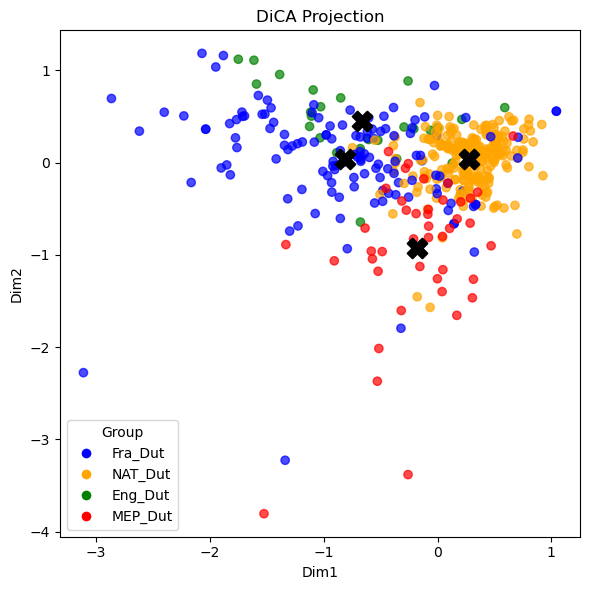

In [5]:

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_dica_projection(axs, data=data_DiCA)

plt.tight_layout()
plt.show()

In [6]:
results_DiCA = {}
data_DiCA_coords = data_DiCA.drop(columns=["lang4", "fileID"]).values  # shape: (n_cells, 4)

c:\Users\Victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


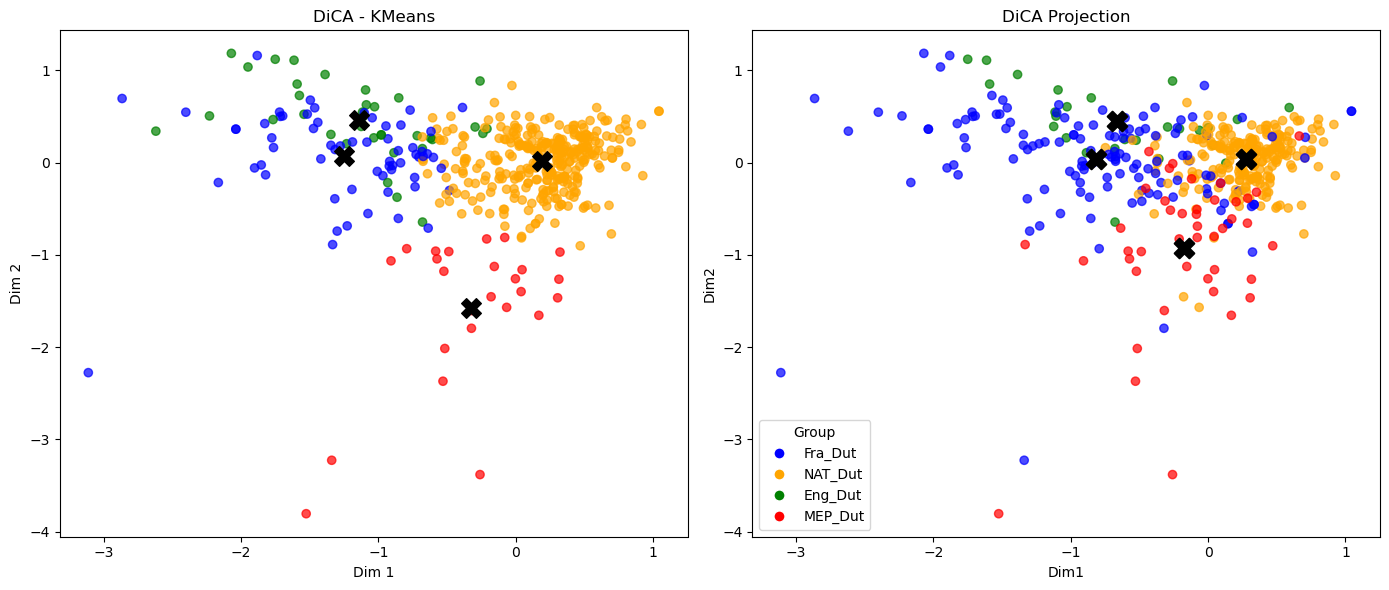

In [50]:
# Number of clusters (adjust as needed)
n_clusters = 4

# Fit KMeans on DiCA
kmeans_DiCA = KMeans(n_clusters=n_clusters, random_state=42)
data_DiCA['kmeans_cluster'] = kmeans_DiCA.fit_predict(data_DiCA[['Dim1', 'Dim2', 'Dim3', 'Dim4']])

results_DiCA["KMeans"] = {
    "cost": kmeans_DiCA.inertia_,
    "silhouette": silhouette_score(data_DiCA[['Dim1', 'Dim2', 'Dim3', 'Dim4']], data_DiCA['kmeans_cluster']),
    "centers": kmeans_DiCA.cluster_centers_,
    "labels": data_DiCA['kmeans_cluster'].values
    
}

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.sca(axs[0])
plot_clusters(data_DiCA_coords, results_DiCA["KMeans"]["labels"],
                 title="DiCA - KMeans", centers=results_DiCA["KMeans"]["centers"])

plot_dica_projection(axs[1], data=data_DiCA)

plt.tight_layout()
plt.show()


# New Analysis

In [43]:
n_clusters = 4
iters = 1000
n_particles = 50

In [52]:
# Run PSO, ABC, and ACOR on DiCA data
start = time.time()
pso_cost_DiCA, pso_centers_DiCA, pso_labels_DiCA, pso_sil_DiCA, pso_pos_history_DiCA, pso_cost_history_DiCA = SI.run_pso(
    data_DiCA_coords, n_clusters, iters//5, n_particles, record_history=True
)
results_DiCA["PSO"] = {
    "cost": pso_cost_DiCA,
    "silhouette": pso_sil_DiCA,
    "centers": pso_centers_DiCA,
    "labels": pso_labels_DiCA,
}
print("PSO run time on DiCA: {:.2f} seconds".format(time.time() - start))

start = time.time()
abc_cost_DiCA, abc_centers_DiCA, abc_labels_DiCA, abc_history_DiCA = SI.run_abc(
    data_DiCA_coords, n_clusters, iters, n_food_sources=30, limit=20, record_history=True
)
results_DiCA["ABC"] = {
    "cost": abc_cost_DiCA,
    "centers": abc_centers_DiCA,
    "labels": abc_labels_DiCA
}
print("ABC run time on DiCA: {:.2f} seconds".format(time.time() - start))

start = time.time()
acor_cost_DiCA, acor_centers_DiCA, acor_labels_DiCA, acor_history_DiCA = SI.run_acor(
    data_DiCA_coords, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)
results_DiCA["ACOR"] = {
    "cost": acor_cost_DiCA,
    "centers": acor_centers_DiCA,
    "labels": acor_labels_DiCA
}
print("ACOR run time on DiCA: {:.2f} seconds".format(time.time() - start))


PSO run time on DiCA: 3.25 seconds
ABC run time on DiCA: 5.92 seconds
ACOR run time on DiCA: 5.61 seconds


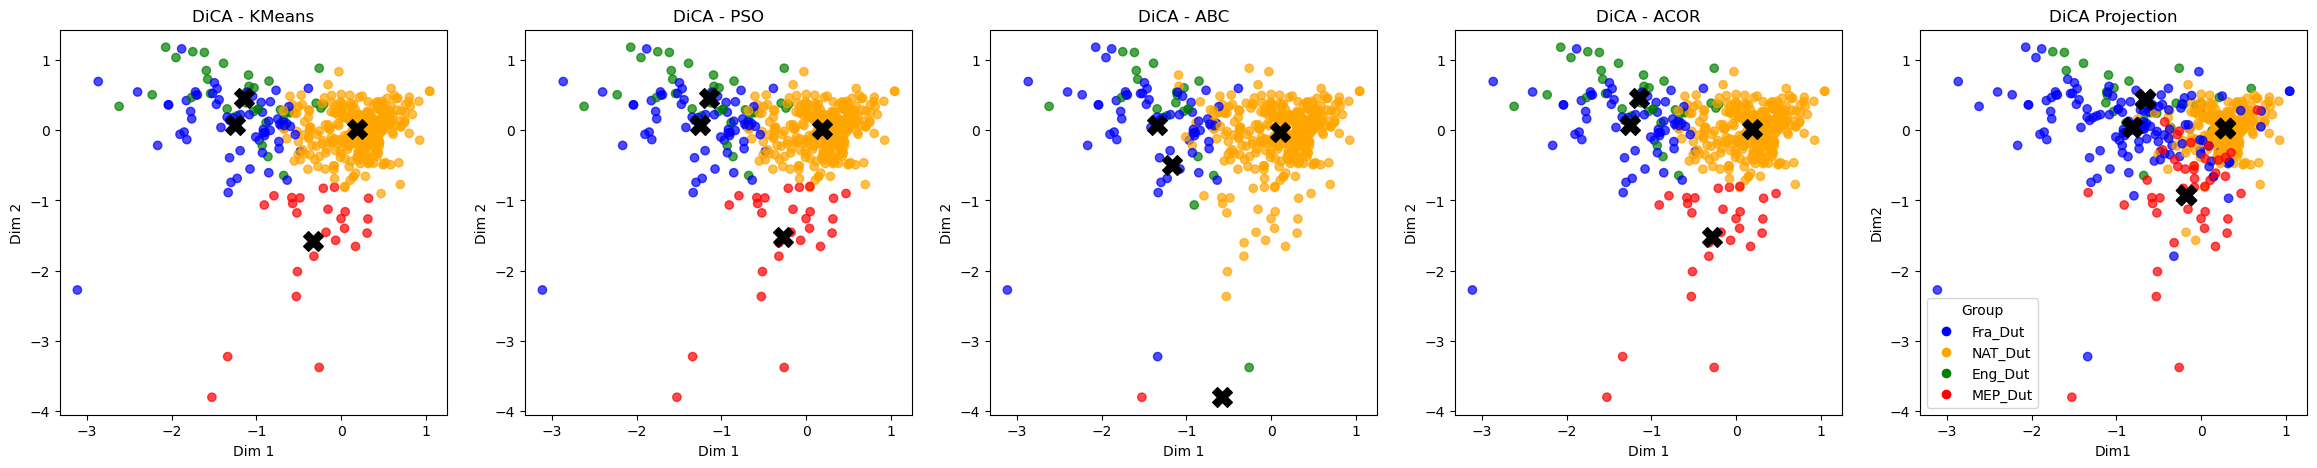

In [53]:
# -------------------------------
# 6. Visualization of Clustering Results - DiCA
# -------------------------------
fig, axs = plt.subplots(1, 5, figsize=(29, 5))

# --- DiCA Results ---
plt.sca(axs[0])
plot_clusters(data_DiCA_coords, results_DiCA["KMeans"]["labels"],
                 title="DiCA - KMeans", centers=results_DiCA["KMeans"]["centers"])

plt.sca(axs[1])
plot_clusters(data_DiCA_coords, results_DiCA["PSO"]["labels"],
                 title="DiCA - PSO", centers=results_DiCA["PSO"]["centers"])

plt.sca(axs[2])
plot_clusters(data_DiCA_coords, results_DiCA["ABC"]["labels"],
                 title="DiCA - ABC", centers=results_DiCA["ABC"]["centers"])

plt.sca(axs[3])
plot_clusters(data_DiCA_coords, results_DiCA["ACOR"]["labels"],
                 title="DiCA - ACOR", centers=results_DiCA["ACOR"]["centers"])

plot_dica_projection(axs[4], data=data_DiCA)
plt.show()

